# OpenPose JSON File

## Import

In [54]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import math
import os
import warnings
from random import randint
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read Data

In [55]:
#READ IMAGE
image = cv2.imread('../DATASET_Juggling/test_images/girls.jpg')

# READ FILE
with open('../DATASET_Juggling/test_images/girls.json') as f:
  data = json.load(f)

In [56]:
# JSON PRETTY PRINT 
print(json.dumps(data, indent = 4))

{
    "version": 1.3,
    "people": [
        {
            "person_id": [
                -1
            ],
            "pose_keypoints_2d": [
                354.433,
                136.398,
                0.79646,
                354.445,
                178.388,
                0.910756,
                329.817,
                186.6,
                0.818131,
                300.642,
                222.16,
                0.891634,
                339.828,
                227.645,
                0.874069,
                381.803,
                182.96,
                0.738916,
                410.988,
                225.833,
                0.854024,
                377.27,
                231.291,
                0.815299,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
       

## Define Keypoints of Interest (KOI)
An array pose_keypoints_2d containing the body part locations and detection confidence formatted as x1,y1,c1,x2,y2,c2,.... The coordinates x and y are in the range [0, source size] while c is the confidence score in the range [0,1]. Analogously, "hand_right_keypoints_2d" and "hand_left_keypoints_2d"

Therefore every three values represents a new body part. Based on the 15 keypoint map in range [0,14] from the `README.md` -> Right Wrist is keypoint 4 and Left Wrist is 7 

In [64]:
person      = 0
right_wrist = 4
left_wrist  = 7
body_keyPts        = data['people'][person]["pose_keypoints_2d"]
right_wrist_keyPts = body_keyPts[3*right_wrist : 3*right_wrist +3]
left_wrist_keyPts  = body_keyPts[3*left_wrist  : 3*left_wrist +3]
right_hand_keyPts  = data['people'][person]["hand_right_keypoints_2d"]
left_hand_keyPts   = data['people'][person]["hand_left_keypoints_2d"]

#Display
print('Body Keypoints :', body_keyPts , '\n')
print('Right Wrist: ' , right_wrist_keyPts)
print('Left Wrist : ' , left_wrist_keyPts , '\n')
print('Right Hand Keypoints:', right_hand_keyPts , '\n')
print('Left Hand Keypoints:' , left_hand_keyPts , '\n')

Body Keypoints : [354.433, 136.398, 0.79646, 354.445, 178.388, 0.910756, 329.817, 186.6, 0.818131, 300.642, 222.16, 0.891634, 339.828, 227.645, 0.874069, 381.803, 182.96, 0.738916, 410.988, 225.833, 0.854024, 377.27, 231.291, 0.815299, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 360.849, 218.507, 0.802096] 

Right Wrist:  [339.828, 227.645, 0.874069]
Left Wrist :  [377.27, 231.291, 0.815299] 

Right Hand Keypoints: [341.961, 227.937, 0.572521, 345.673, 224.562, 0.629498, 352.085, 223.043, 0.829011, 356.81, 225.406, 0.701449, 360.353, 226.587, 0.670368, 352.591, 228.274, 0.728737, 357.822, 231.986, 0.682392, 361.366, 234.349, 0.757207, 364.74, 236.542, 0.677258, 351.916, 231.48, 0.565338, 356.978, 235.192, 0.609277, 361.534, 237.555, 0.6141, 365.922, 239.748, 0.541571, 350.06, 233.842, 0.58238, 354.785, 237.217, 0.441446, 359.003, 239.242, 0.33906, 363.39, 240.423, 0.230408, 348.204, 236.711, 0.536276, 352.085, 238.567, 0.437584, 354.785, 239.917, 0.404646, 356.978, 241.098, 0

## Helper Functions

In [68]:
def draw_keyPts(img,key_list,color):
    """
    Draws on a color image the key_list given.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Key List
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            (x,y) = int(key_list[i]),int(key_list[i+1])
            cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 1, 0) 
    return output_img

def draw_hand_boundaries(img,key_list,radius):
    """
    Draws on a color image the hand boundaries which are defined by circles of
    size radius to every circle center in the key_list given.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Key List
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            (x,y) = int(key_list[i]),int(key_list[i+1])
            cv2.circle(img_to_draw, (x,y), radius= radius, color=[255, 255, 102], thickness=2)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 1, 0) 
    return output_img



## Draw KOI and Hand Boundaries

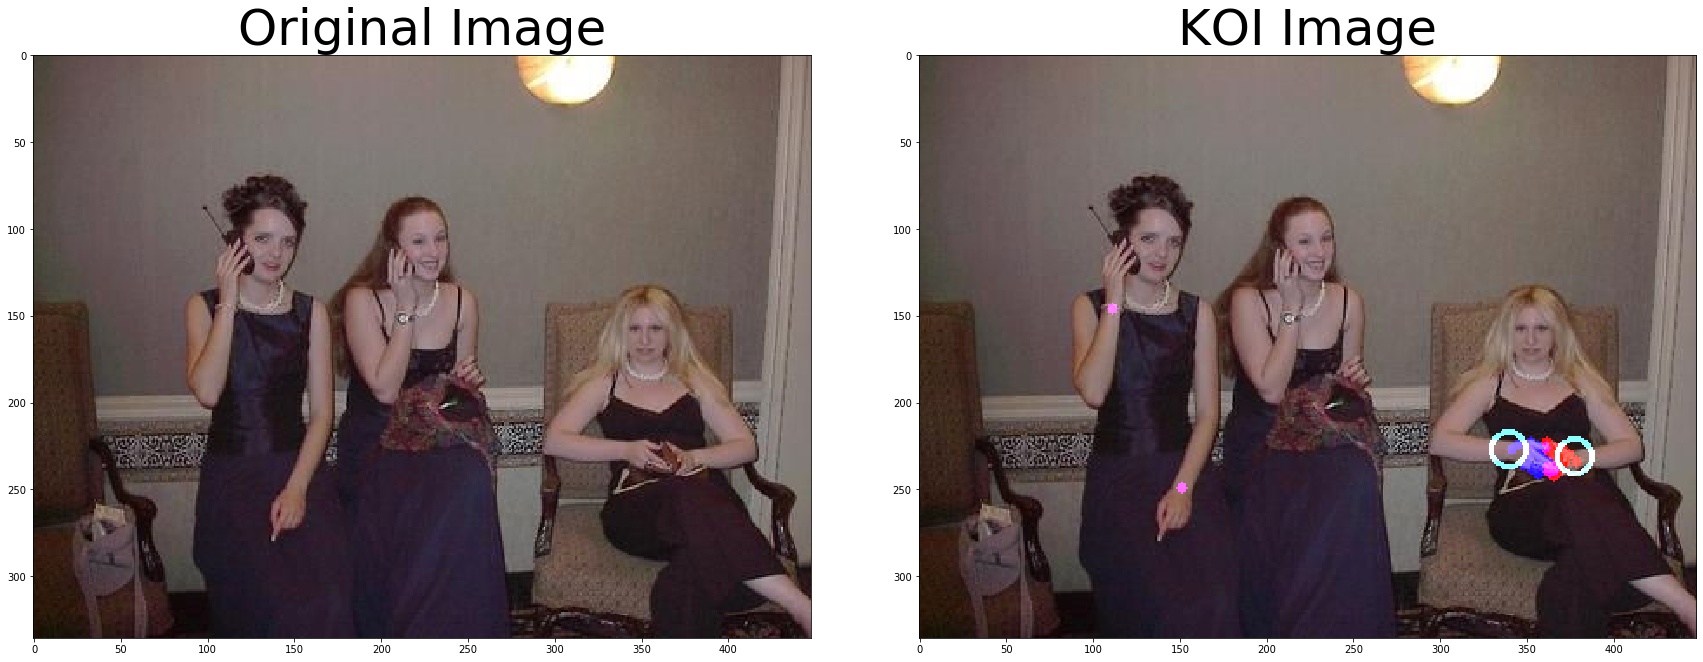

In [69]:
#Wrists
wrist_keyPts = np.hstack((right_wrist_keyPts, left_wrist_keyPts))
color = [255, 0, 255]
out_image = draw_keyPts(image, wrist_key, color)

#Hands
color = [255, 0, 0]
out_image = draw_keyPts(out_image, right_hand_keyPts,color)
color = [0, 0, 255]
out_image = draw_keyPts(out_image, left_hand_keyPts,color)

#Boundaries
radius = 10
hand_centroids = wrist_keyPts #FOR NOW LET's DEFINE IT THIS WAY!!!!!!!!
out_image = draw_hand_boundaries(out_image,hand_centroids,radius)

# Display 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax2.set_title('KOI Image', fontsize=50)
ax2.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))
